## We wrote this code with the help of the following scripts

https://github.com/dipuk0506/SpinalNet/blob/master/Transfer%20Learning/Pytorch_data_to_folders.py

https://github.com/dipuk0506/SpinalNet/blob/master/Transfer%20Learning/Transfer_Learning_STL10.py

In [1]:
from __future__ import print_function, division

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy

import random
#random.seed(0)
#np.random.seed(0)
#torch.manual_seed(0)

plt.ion()   # interactive mode
import imageio
import os




folderlocation = './data/'
os.mkdir(folderlocation)
folderlocation = './data/STL10/'
os.mkdir(folderlocation)
path = folderlocation
if not os.path.exists(path):
    os.mkdir(path)

path = folderlocation + 'train/'
if not os.path.exists(path):
    os.mkdir(path)
        
path = folderlocation + 'valid/'
if not os.path.exists(path):
    os.mkdir(path)

path = folderlocation + 'test/'
if not os.path.exists(path):
    os.mkdir(path)
    
for iter1 in range(10):    # 10 = number of classes
    path = folderlocation + 'train/'+str(iter1)
    if not os.path.exists(path):
        os.mkdir(path)
    path = folderlocation + 'valid/'+str(iter1)
    if not os.path.exists(path):
        os.mkdir(path)
    
    path = folderlocation + 'test/'+str(iter1)
    if not os.path.exists(path):
        os.mkdir(path)

        
data_train = torchvision.datasets.STL10('/files/', split='train', download=True,
                             transform=torchvision.transforms.Compose([
                             ]))
        
for iter1 in range(len(data_train)):
    x, a = data_train[iter1] 
    if iter1%10 ==0:
        imageio.imwrite(folderlocation + 'valid/'+str(a)+'/valid'+str(iter1)+'.png', x)
    else:
        imageio.imwrite(folderlocation + 'train/'+str(a)+'/train'+str(iter1)+'.png', x)
    
data_test = torchvision.datasets.STL10('/files/', split='test', download=True,
                             transform=torchvision.transforms.Compose([
                             ]))

for iter1 in range(len(data_test)):
    x, a = data_test[iter1] 
    imageio.imwrite(folderlocation + 'test/'+str(a)+'/test'+str(iter1)+'.png', x)



  0%|          | 0/2640397119 [00:00<?, ?it/s]

Extracting /files/stl10_binary.tar.gz to /files/
Files already downloaded and verified


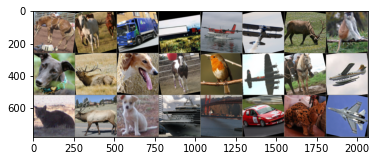

In [2]:
# Data augmentation and normalization for training
# Just normalization for validation
data_transforms = {
    'train': transforms.Compose([
        transforms.Resize((272,272)),
        transforms.RandomRotation(15,),
        transforms.RandomCrop(256),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.507, 0.487, 0.441], std=[0.267, 0.256, 0.276])
    ]),
    'valid': transforms.Compose([
        transforms.Resize(256),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.507, 0.487, 0.441], std=[0.267, 0.256, 0.276])
    ]),
    'test': transforms.Compose([
        transforms.Resize(256),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.507, 0.487, 0.441], std=[0.267, 0.256, 0.276])
    ]),
}


image_datasets = {x: datasets.ImageFolder(os.path.join(folderlocation, x),
                                          data_transforms[x])
                  for x in ['train', 'valid', 'test']}
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=24,
                                             shuffle=True, num_workers=0)
              for x in ['train', 'valid', 'test']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'valid', 'test']}
class_names = image_datasets['train'].classes

device = 'cuda'#torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.507, 0.487, 0.441])
    std = np.array([0.267, 0.256, 0.276])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated


# Get a batch of training data
inputs, classes = next(iter(dataloaders['train']))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

#import matplotlib.pyplot as plt
#plt.rcParams["figure.dpi"] = 200

#plt.savefig('Transformed.pdf')  

imshow(out)#, title=[class_names[x] for x in classes])

In [3]:

# model_ft = models.vgg19_bn(pretrained=True)
# num_ftrs = model_ft.classifier[0].in_features

model_ft = models.wide_resnet101_2(pretrained=True)
num_ftrs = model_ft.fc.in_features

half_in_size = round(num_ftrs/2)
layer_width = 512
Num_class=10

class SpinalNet(nn.Module):
    def __init__(self):
        super(SpinalNet, self).__init__()
        
        self.fc_spinal_layer1 = nn.Sequential(
            nn.Dropout(p = 0.5), nn.Linear(half_in_size, layer_width),
            nn.BatchNorm1d(layer_width), nn.ReLU(inplace=True),)
        self.fc_spinal_layer2 = nn.Sequential(
            nn.Dropout(p = 0.5), nn.Linear(half_in_size+layer_width, layer_width),
            nn.BatchNorm1d(layer_width), nn.ReLU(inplace=True),)
        self.fc_spinal_layer3 = nn.Sequential(
            nn.Dropout(p = 0.5), nn.Linear(half_in_size+layer_width, layer_width),
            nn.BatchNorm1d(layer_width), nn.ReLU(inplace=True),)
        self.fc_spinal_layer4 = nn.Sequential(
            nn.Dropout(p = 0.5), nn.Linear(half_in_size+layer_width, layer_width),
            nn.BatchNorm1d(layer_width), nn.ReLU(inplace=True),)
        self.fc_out = nn.Sequential(
            nn.Dropout(p = 0.5), nn.Linear(layer_width*4, Num_class),)
        
        

    def forward(self, x):
        x1 = self.fc_spinal_layer1(x[:, 0:half_in_size])
        x2 = self.fc_spinal_layer2(torch.cat([ x[:,half_in_size:2*half_in_size], x1], dim=1))
        x3 = self.fc_spinal_layer3(torch.cat([ x[:,0:half_in_size], x2], dim=1))
        x4 = self.fc_spinal_layer4(torch.cat([ x[:,half_in_size:2*half_in_size], x3], dim=1))
        
        
        x = torch.cat([x1, x2], dim=1)
        x = torch.cat([x, x3], dim=1)
        x = torch.cat([x, x4], dim=1)

        
        x = self.fc_out(x)
        return x



net_fc = nn.Sequential(
            nn.Linear(512, 4096),
            nn.ReLU(inplace=True),
            nn.Dropout(),
            nn.Linear(4096, 4096),
            nn.ReLU(inplace=True),
            nn.Dropout(),
            nn.Linear(4096, Num_class)
        )

#%%




def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0
    test_token=0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'valid', 'test']:
             
            
            '''
            Test when a better validation result is found
            '''
            if test_token ==0 and phase == 'test':
                continue
            test_token =0
            
            
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
            if phase == 'train':
                scheduler.step()

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))

            # deep copy the model
            if phase == 'valid' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())
                test_token =1


        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model


Downloading: "https://download.pytorch.org/models/wide_resnet101_2-32ee1156.pth" to /root/.cache/torch/hub/checkpoints/wide_resnet101_2-32ee1156.pth


  0%|          | 0.00/243M [00:00<?, ?B/s]

In [4]:
'''
Changing the fully connected layer to SpinalNet
'''

#model_ft.fc = nn.Linear(num_ftrs, 10)
model_ft.fc = SpinalNet()



model_ft = model_ft.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

model_ft = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler,
                       num_epochs=20)

Epoch 0/19
----------
train Loss: 0.8494 Acc: 0.7380
valid Loss: 0.1263 Acc: 0.9660
test Loss: 0.1110 Acc: 0.9691

Epoch 1/19
----------
train Loss: 0.1809 Acc: 0.9480
valid Loss: 0.0912 Acc: 0.9700
test Loss: 0.0878 Acc: 0.9741

Epoch 2/19
----------
train Loss: 0.1249 Acc: 0.9627
valid Loss: 0.0744 Acc: 0.9820
test Loss: 0.0638 Acc: 0.9796

Epoch 3/19
----------
train Loss: 0.0873 Acc: 0.9736
valid Loss: 0.0681 Acc: 0.9840
test Loss: 0.0685 Acc: 0.9798

Epoch 4/19
----------
train Loss: 0.0689 Acc: 0.9784
valid Loss: 0.0690 Acc: 0.9840

Epoch 5/19
----------
train Loss: 0.0435 Acc: 0.9882
valid Loss: 0.0876 Acc: 0.9720

Epoch 6/19
----------
train Loss: 0.0488 Acc: 0.9871
valid Loss: 0.0895 Acc: 0.9840

Epoch 7/19
----------
train Loss: 0.0353 Acc: 0.9922
valid Loss: 0.0846 Acc: 0.9800

Epoch 8/19
----------
train Loss: 0.0305 Acc: 0.9929
valid Loss: 0.0753 Acc: 0.9840

Epoch 9/19
----------
train Loss: 0.0297 Acc: 0.9924
valid Loss: 0.0753 Acc: 0.9820

Epoch 10/19
----------
train L

# Delete Downloaded Data

In [5]:
import shutil
shutil.rmtree('./data/')